# Univariate ARIMA Models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

We use the data for the Vestas Wind stock and Next Era Energy stock. 

In [5]:
DATA_STORE = '/Users/chris/Desktop/Stocks/Data_Gathering/Stocks/assets.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    VWSYF = (store['Stocks/prices']
              .loc[idx[:], 'Close',]
              .unstack('Symbol')
              .loc[idx[:], 'VWSYF',]
              .squeeze().dropna())

In [7]:
with pd.HDFStore(DATA_STORE) as store:
    NEE = (store['Stocks/prices']
              .loc[idx[:], 'Close',]
              .unstack('Symbol')
              .loc[idx[:], 'NEE',]
              .squeeze().dropna())

### Log Transformation

In [8]:
VWSYF_log = np.log(VWSYF)
NEE_log = np.log(NEE)

### Differencing

In [9]:
VWSYF_log_diff = VWSYF_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
NEE_log_diff = NEE_log.diff(12).dropna()

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various **(p, q)** lag combinations and collect diagnostic statistics to compare the result.

In [14]:
train_size = 60
results = {}
y_true = NEE_log_diff.iloc[train_size:]

for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        
        convergence_error = stationarity_error = 0
        y_pred = []
        
        for T in range(train_size, len(NEE_log_diff)):
            train_set = NEE_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
                
            except LinAlgError:
                convergence_error += 1
                
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [15]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, (0, 1) to (4, 4)
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          24 non-null     float64
 1   AIC           24 non-null     float64
 2   BIC           24 non-null     float64
 3   convergence   24 non-null     float64
 4   stationarity  24 non-null     float64
dtypes: float64(5)
memory usage: 1.2 KB


In [16]:
with pd.HDFStore('arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [17]:
arma_results.nsmallest(5, columns=['RMSE'])

RMSE         AIC         BIC  convergence  stationarity
p q                                                             
2 1  0.024696 -240.853007 -230.381285          0.0           0.0
  0  0.024792 -241.824756 -233.447378          0.0           0.0
1 0  0.024819 -242.862058 -236.579024          0.0           0.0
  1  0.024869 -241.644694 -233.267315          0.0           0.0
3 1  0.025428 -244.796889 -232.230821          6.0           0.0

In [18]:
arma_results.nsmallest(5, columns=['BIC'])

,,RMSE,AIC,BIC,convergence,stationarity
p,q,,,,,
0,3,0.036855,-253.027364,-242.965150,0.0,55.0
1,0,0.024819,-242.862058,-236.579024,0.0,0.0
2,0,0.024792,-241.824756,-233.447378,0.0,0.0
1,1,0.024869,-241.644694,-233.267315,0.0,0.0
2,2,0.027543,-245.833293,-233.267225,2.0,0.0


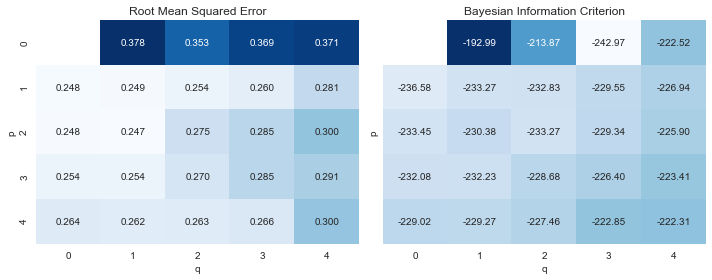

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [20]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

p  q
1  0    2.5
2  0    2.5
1  1    4.0
2  1    5.0
1  2    6.0
dtype: float64

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [21]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [22]:
best_arma_model = tsa.ARMA(endog=NEE_log_diff, order=(best_p, best_q)).fit()
print(best_arma_model.summary())

                              ARMA Model Results                              
Dep. Variable:                    NEE   No. Observations:                  239
Model:                     ARMA(1, 0)   Log Likelihood                 452.271
Method:                       css-mle   S.D. of innovations              0.036
Date:                Tue, 05 Jan 2021   AIC                           -898.542
Time:                        10:15:02   BIC                           -888.113
Sample:                             0   HQIC                          -894.339
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.021      0.620      0.535      -0.028       0.053
ar.L1.NEE      0.8900      0.029     30.920      0.000       0.834       0.946
                                    Roots           

### Check Residual Correlogram

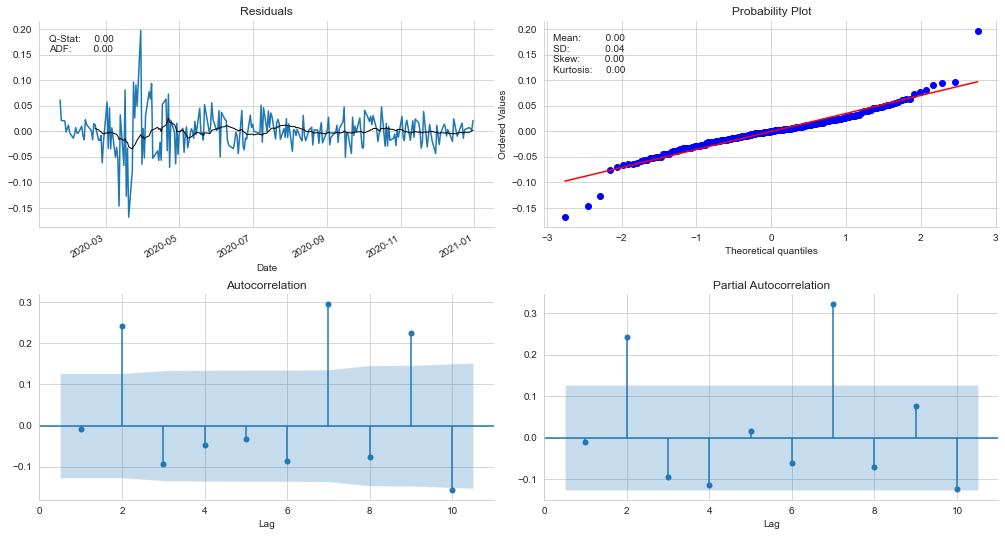

In [23]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [24]:
sarimax_model = tsa.SARIMAX(endog=NEE_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [25]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  239
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                 525.447
Date:                              Tue, 05 Jan 2021   AIC                          -1036.895
Time:                                      10:15:06   BIC                          -1012.560
Sample:                                           0   HQIC                         -1027.088
                                              - 239                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5882      0.179      3.280      0.001       0.237       0.940
ar.L2          0.38

### Finding the optimal number of lags

In [29]:
train_size = 60 # 5 years of training data
results = {}
test_set = NEE_log_diff.iloc[train_size:]

for p1 in range(4):
    for q1 in range(4):
        for p2 in range(3):
            for q2 in range(3):
                preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
                aic, bic = [], []
                if p1 == 0 and q1 == 0:
                    continue
                print(p1, q1, p2, q2)
                convergence_error = stationarity_error = 0
                y_pred = []
                for i, T in enumerate(range(train_size, len(NEE_log_diff))):
                    train_set = NEE_log_diff.iloc[T-train_size:T]
                    try:
                        with warnings.catch_warnings():
                            warnings.filterwarnings("ignore")
                            model = tsa.SARIMAX(endog=train_set.values,
                                            order=(p1, 0, q1),
                                            seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
                    except LinAlgError:
                        convergence_error += 1
                    except ValueError:
                        stationarity_error += 1

                    preds.iloc[i, 1] = model.forecast(steps=1)[0]
                    aic.append(model.aic)
                    bic.append(model.bic)
 
                preds.dropna(inplace=True)
                mse = mean_squared_error(preds.y_true, preds.y_pred)
                results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                                  preds.y_true.sub(preds.y_pred).pow(2).std(),
                                                  np.mean(aic),
                                                  np.std(aic),                                                  
                                                  np.mean(bic),
                                                  np.std(bic),                                                  
                                                  convergence_error,
                                                  stationarity_error]

0 1 0 0
0 1 0 1
0 1 0 2
0 1 1 0
0 1 1 1
0 1 1 2
0 1 2 0
0 1 2 1
0 1 2 2
0 2 0 0
0 2 0 1
0 2 0 2
0 2 1 0
0 2 1 1
0 2 1 2
0 2 2 0
0 2 2 1
0 2 2 2
0 3 0 0
0 3 0 1
0 3 0 2
0 3 1 0
0 3 1 1
0 3 1 2
0 3 2 0
0 3 2 1
0 3 2 2
1 0 0 0
1 0 0 1
1 0 0 2
1 0 1 0
1 0 1 1
1 0 1 2
1 0 2 0
1 0 2 1
1 0 2 2
1 1 0 0
1 1 0 1
1 1 0 2
1 1 1 0
1 1 1 1
1 1 1 2
1 1 2 0
1 1 2 1
1 1 2 2
1 2 0 0
1 2 0 1
1 2 0 2
1 2 1 0
1 2 1 1
1 2 1 2
1 2 2 0
1 2 2 1
1 2 2 2
1 3 0 0
1 3 0 1
1 3 0 2
1 3 1 0
1 3 1 1
1 3 1 2
1 3 2 0
1 3 2 1
1 3 2 2
2 0 0 0
2 0 0 1
2 0 0 2
2 0 1 0
2 0 1 1
2 0 1 2
2 0 2 0
2 0 2 1
2 0 2 2
2 1 0 0
2 1 0 1
2 1 0 2
2 1 1 0
2 1 1 1
2 1 1 2
2 1 2 0
2 1 2 1
2 1 2 2
2 2 0 0
2 2 0 1
2 2 0 2
2 2 1 0
2 2 1 1
2 2 1 2
2 2 2 0
2 2 2 1
2 2 2 2
2 3 0 0
2 3 0 1
2 3 0 2
2 3 1 0
2 3 1 1
2 3 1 2
2 3 2 0
2 3 2 1
2 3 2 2
3 0 0 0
3 0 0 1
3 0 0 2
3 0 1 0
3 0 1 1
3 0 1 2
3 0 2 0
3 0 2 1
3 0 2 2
3 1 0 0
3 1 0 1
3 1 0 2
3 1 1 0
3 1 1 1
3 1 1 2
3 1 2 0
3 1 2 1
3 1 2 2
3 2 0 0
3 2 0 1
3 2 0 2
3 2 1 0
3 2 1 1
3 2 1 2
3 2 2 0
3 2 2 1


### Compare model metrics

In [30]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135 entries, (0, 1, 0, 0) to (3, 3, 2, 2)
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RMSE          135 non-null    float64
 1   RMSE_std      135 non-null    float64
 2   AIC           135 non-null    float64
 3   AIC_std       135 non-null    float64
 4   BIC           135 non-null    float64
 5   BIC_std       135 non-null    float64
 6   convergence   135 non-null    float64
 7   stationarity  135 non-null    float64
 8   CV            135 non-null    float64
dtypes: float64(9)
memory usage: 10.3 KB


In [31]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [32]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [33]:
sarimax_results.nsmallest(5, columns='RMSE')

RMSE  RMSE_std         AIC    AIC_std         BIC    BIC_std  \
p1 q1 p2 q2                                                                     
2  1  0  1   0.019431  0.000678 -259.468207  49.519137 -248.996484  49.519137   
1  2  0  1   0.019578  0.000656 -261.976271  47.047061 -251.504548  47.047061   
2  0  1  2   0.019752  0.000674 -258.657254  50.441390 -246.091187  50.441390   
   1  1  1   0.019815  0.000648 -258.025348  49.304684 -245.459281  49.304684   
   0  0  1   0.019815  0.000709 -261.002183  49.990448 -252.624805  49.990448   

             convergence  stationarity        CV  
p1 q1 p2 q2                                       
2  1  0  1           0.0           0.0  0.034890  
1  2  0  1           0.0           0.0  0.033510  
2  0  1  2           0.0           0.0  0.034144  
   1  1  1           0.0           0.0  0.032711  
   0  0  1           0.0           0.0  0.035782

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [34]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

RMSE         AIC         BIC
p1 q1 p2 q2                                  
2  1  0  1   0.019431 -259.468207 -248.996484
1  2  0  1   0.019578 -261.976271 -251.504548
2  0  1  2   0.019752 -258.657254 -246.091187
   1  1  1   0.019815 -258.025348 -245.459281
   0  0  1   0.019815 -261.002183 -252.624805

In [35]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

,RMSE,AIC,BIC
RMSE,1.000000,0.902717,0.823276
AIC,0.902717,1.000000,0.928748
BIC,0.823276,0.928748,1.000000


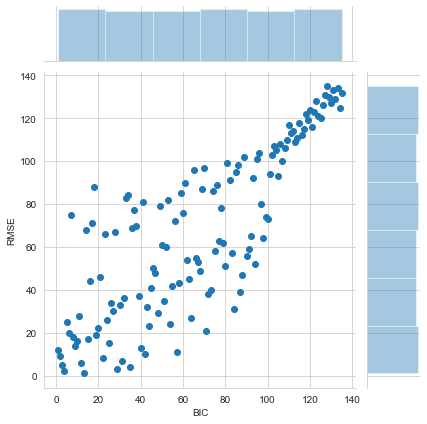

In [36]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [37]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

,,,,RMSE,RMSE_std,AIC,AIC_std,BIC,BIC_std,convergence,stationarity,CV
p1,q1,p2,q2,,,,,,,,,
2,1,0,1,0.019431,0.000678,-259.468207,49.519137,-248.996484,49.519137,0.0,0.0,0.034890
1,2,0,1,0.019578,0.000656,-261.976271,47.047061,-251.504548,47.047061,0.0,0.0,0.033510
2,0,0,1,0.019815,0.000709,-261.002183,49.990448,-252.624805,49.990448,0.0,0.0,0.035782
1,1,1,1,0.019865,0.000703,-259.507325,50.117858,-249.035602,50.117858,0.0,0.0,0.035403


### Train best model

In [38]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [39]:
best_model = tsa.SARIMAX(endog=NEE_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [40]:
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  239
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2], 12)   Log Likelihood                 525.795
Date:                                 Tue, 05 Jan 2021   AIC                          -1033.590
Time:                                         12:34:17   BIC                          -1002.302
Sample:                                              0   HQIC                         -1020.982
                                                 - 239                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1504      0.116      1.292      0.196      -0.078       0

### Check Residual Correlogram

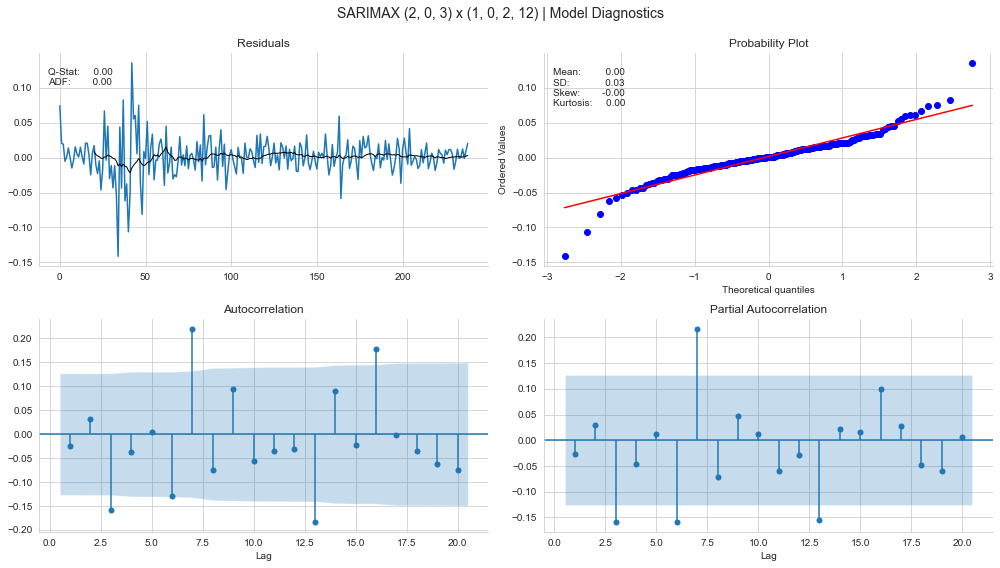

In [41]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')

In [42]:
best_model.save('arima_model.pkl')